## 1. Data Understanding

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('transfusion.data')
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [3]:
df = df.rename(columns = {'Recency (months)': 'Recency', 'Frequency (times)': 'Frequency','Monetary (c.c. blood)': 'Monetary', 'Time (months)': 'Time','whether he/she donated blood in March 2007':'Class'})
df.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [4]:
df.shape

(748, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [6]:
df.describe()

,Recency,Frequency,Monetary,Time,Class
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [7]:
df.isnull().sum()

Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64

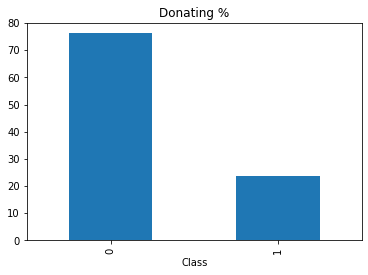

In [8]:
donated = df.groupby(['Class']).count()['Time']/df.shape[0] * 100
figure, ax = plt.subplots()
donated.plot(kind ='bar', title = 'Donating %', ax = ax);

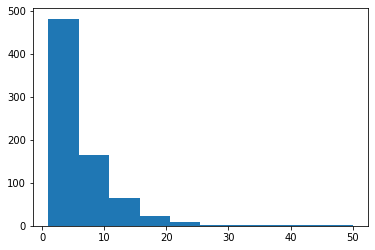

In [9]:
plt.hist(df['Frequency']);

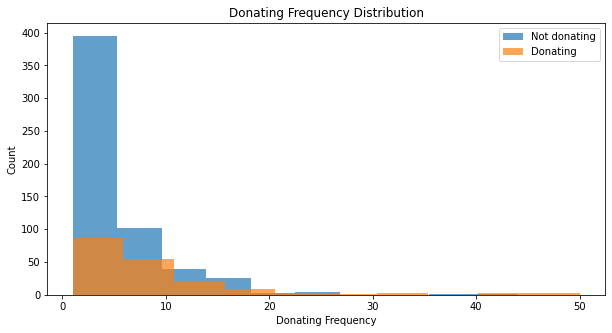

In [10]:
figure, ax = plt.subplots(figsize = (10, 5))
ax.hist(df[df['Class'] == 0]['Frequency'], alpha = 0.7, label = 'Not donating')
ax.hist(df[df['Class'] == 1]['Frequency'],  alpha = 0.7, label = 'Donating')
plt.xlabel('Donating Frequency')
plt.ylabel('Count')
plt.title('Donating Frequency Distribution')
plt.legend()
plt.show()

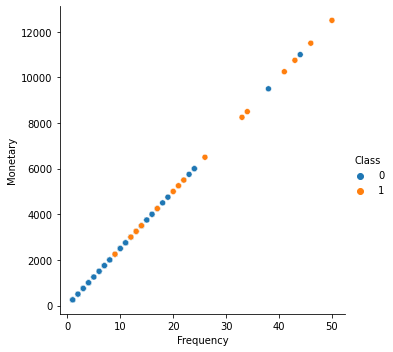

In [11]:
sns.relplot(x = 'Frequency', y = 'Monetary', data = df, hue = 'Class');

## 2. Data Preparation

In [12]:
df['Time_diff'] = df['Time'] - df['Recency']
df.head()

,Recency,Frequency,Monetary,Time,Class,Time_diff
0,2,50,12500,98,1,96
1,0,13,3250,28,1,28
2,1,16,4000,35,1,34
3,2,20,5000,45,1,43
4,1,24,6000,77,0,76


### 2.1. Feature Scaling

In [13]:
scaler = MinMaxScaler()
features = ['Recency', 'Frequency', 'Monetary', 'Time', 'Time_diff']
scaled_df = pd.DataFrame(data = df)
scaled_df[features] = scaler.fit_transform(df[features])
scaled_df.head()

,Recency,Frequency,Monetary,Time,Class,Time_diff
0,0.027027,1.000000,1.000000,1.000000,1,1.000000
1,0.000000,0.244898,0.244898,0.270833,1,0.291667
2,0.013514,0.306122,0.306122,0.343750,1,0.354167
3,0.027027,0.387755,0.387755,0.447917,1,0.447917
4,0.013514,0.469388,0.469388,0.781250,0,0.791667


### 2.2. Feature Selection

#### 2.2.1 Features Group 1

In [14]:
processed_df1 = scaled_df[['Recency', 'Frequency', 'Monetary', 'Time', 'Class']]
processed_df1.head()

,Recency,Frequency,Monetary,Time,Class
0,0.027027,1.000000,1.000000,1.000000,1
1,0.000000,0.244898,0.244898,0.270833,1
2,0.013514,0.306122,0.306122,0.343750,1
3,0.027027,0.387755,0.387755,0.447917,1
4,0.013514,0.469388,0.469388,0.781250,0


#### 2.2.2 Features Group 2

In [15]:
processed_df2 = scaled_df[['Frequency', 'Monetary','Time_diff', 'Class']]
processed_df2.head()

,Frequency,Monetary,Time_diff,Class
0,1.000000,1.000000,1.000000,1
1,0.244898,0.244898,0.291667,1
2,0.306122,0.306122,0.354167,1
3,0.387755,0.387755,0.447917,1
4,0.469388,0.469388,0.791667,0


## 3. Modeling

### 3.1 Split Data

#### 3.1.1 Features Group 1

In [16]:
X = processed_df1[['Recency', 'Frequency', 'Monetary', 'Time']]
y = processed_df1[['Class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### 3.1.2 Features Group 2

In [17]:
X2 = processed_df2[['Frequency', 'Monetary', 'Time_diff']]
y2 = processed_df2[['Class']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 0)

### 3.2 Train and Evaluate Models

In [18]:
def train_classifier(classifier, X_train, y_train, X_test, y_test): 
    clf = classifier.fit(X_train, y_train)
    predictions_test = clf.predict(X_test)
    result = accuracy_score(y_test, predictions_test)
    print("{} training...".format(clf.__class__.__name__))
    return result

In [19]:
clf_1 = DecisionTreeClassifier()
clf_2 = RandomForestClassifier(random_state = 0)
clf_3 = SVC(random_state = 0)

#### 3.1.1 Features Group 1

In [20]:
for clf in [clf_1, clf_2, clf_3]:
    clf_name = clf.__class__.__name__
    result = train_classifier(clf, X_train, y_train, X_test, y_test)
    print("Accuracy score on testing data: {:.4f}".format(result))
    print('------------')

DecisionTreeClassifier training...
Accuracy score on testing data: 0.7000
------------
RandomForestClassifier training...
Accuracy score on testing data: 0.7267
------------
SVC training...
Accuracy score on testing data: 0.7333
------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 3.1.2 Features Group 2

In [21]:
for clf in [clf_1, clf_2, clf_3]:
    clf_name = clf.__class__.__name__
    result = train_classifier(clf, X_train2, y_train2, X_test2, y_test2)
    print("Accuracy score on testing data: {:.4f}".format(result))
    print('------------')

DecisionTreeClassifier training...
Accuracy score on testing data: 0.6467
------------
RandomForestClassifier training...
Accuracy score on testing data: 0.7000
------------
SVC training...
Accuracy score on testing data: 0.7400
------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 3.3 Improving Results

In [22]:
def tune_model(classifier, X_train, y_train, X_test, y_test, parameters):
    results = {}
    scorer = make_scorer(accuracy_score, greater_is_better = True)
    grid_obj = GridSearchCV(classifier, parameters, scoring = scorer)
    grid_fit = grid_obj.fit(X_train, y_train)
    best_clf = grid_fit.best_estimator_
    best_params = grid_obj.best_params_
    best_predictions = best_clf.predict(X_test)
    acc = accuracy_score(y_test, best_predictions)
    print("{} Tuning...".format(classifier.__class__.__name__))
    return acc, best_params

#### 3.3.1 Random Forest - Features Group 1

In [29]:
rf_parameters = {'max_depth': [5],
 'min_samples_leaf':  [3],
 'min_samples_split': [2],
 'criterion' : ['gini'],
 'n_estimators': [200]}
rf_acc, rf_best_params = tune_model(clf_2, X_train, y_train, X_test, y_test, rf_parameters)
print("Best Parameters: {}".format(rf_best_params))
print("Accuracy score on testing data: {:.4f}".format(rf_acc))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

RandomForestClassifier Tuning...
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy score on testing data: 0.7800


#### 3.1.2 SVM - Features Group 1

In [ ]:
svm_parameters = {'kernel': ['linear', 'rbf', 'poly'], 
                  'C': [0.5, 1, 1.5], 
                  'gamma': ['scale', 'auto'] }
svm_acc, svm_best_params = tune_model(clf_3, X_train, y_train, X_test, y_test, svm_parameters)
print("Best Parameters: {}".format(svm_best_params))
print("Accuracy score on testing data: {:.4f}".format(svm_acc))

#### 3.1.3 SVM - Features Group 2

In [ ]:
svm_acc, svm_best_params = tune_model(clf_3, X_train2, y_train2, X_test2, y_test2, svm_parameters)
print("Best Parameters: {}".format(svm_best_params))
print("Accuracy score on testing data: {:.4f}".format(svm_acc))

### 3.4 Using Best Model

In [27]:
rf_clf = RandomForestClassifier (criterion = 'gini', max_depth = 5, min_samples_leaf = 3, min_samples_split = 2, n_estimators = 200)

rf_clf = rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print ('Classification Report')
print ('---------------------')
print()
print(classification_report(y_test, rf_pred))
print()
print ('Confusion matrix')
print ('---------------------')
print()
print(confusion_matrix(y_test,rf_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Classification Report
---------------------

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       109
           1       0.68      0.41      0.52        41

    accuracy                           0.79       150
   macro avg       0.74      0.67      0.69       150
weighted avg       0.77      0.79      0.77       150


Confusion matrix
---------------------

[[101   8]
 [ 24  17]]


In [32]:
pickle.dump(rf_clf,open('blood_donation_model.pkl','wb'))